In [ ]:
# !pip install git+https://github.com/NVIDIA-Merlin/models.git

# Environment Setup

Push a Nvidia repo to your artifact repository - (create a new repo if not available)

### Further instructions on how to build a Merlin container can be found [here](https://github.com/jswortz/merlin-gcp)

Guide
1. In an notebook instance run from a terminal `git clone https://github.com/jswortz/merlin-gcp`
2. Run the notebook - this will build a merlin tensorflow image. You can change the base images from NVidia if you choose - this was tested from the version in the repo
3. This will build a container image and save it to artifact registry repository. You may need to enable the artifact repository service
4. Create a new custom workbench by clicking "New Notebook" > "Customize"

<img src="img/custom_workbench.png" width="500"/>

5. To get to the screen for artifact repository. First select "Advanced" then name, select region, then go to "Environment"

<img src="img/workbench-environment.png" width="500"/>

6. Select the your repo and respective image

<img src="img/image.png" width="500"/>

7. Finally, if you already followed the instructions in notebook 02 setup - make sure the new workbench network is in the VPC peered network used for matching engine

# Training with Merlin

## Spotify example

Our goal is to enable the architecture below with Vertex AI and the Merlin Models framework

![](img/arch.png)

## Goals

The goal of this notebook is to create a simple two tower model with Nvtabular and Merlin Models

1. Export data to Parquet for use in Nvtabular
2. Create a NVtabular workflow and fit it to the data
3. Save the fitted workflow to GCS (contains all dictionary lookups)
4. Transform the data into GPU-optimized features from the NVtabular workflow and save to gcs
5. Load the data again as a Merlin dataset using the workflow
6. Create a two tower model in a few lines of code
7. Train a two tower model
8. Save the model (for deployment in notebook 03)
9. Export the embeddings and save to gcs (for deployment to matching engine)

*Based heavily on [this](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb) NVIDIA resource


Data is loaded from BQ - to parquet using the job configuration below


Info on the data

* track_uri_seed counts: 2249561
* artist_uri_seed counts: 294110
* album_uri_seed counts: 730377

# Export Data From BigQuery to Parquet on GCS

In [1]:
PROJECT = 'wortz-project-352116'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1'
# path = 'gs://two-tower-models' #TODO change to your model directory
BUCKET = 'gs://spotify-jsw-mpd-2023'
DATASET_ID = 'spotify_e2e_test'
TABLE = 'train_flatten_last_5'
TABLE_VALIDATION = 'train_flatten_valid_last_5'


import os

from google.cloud import bigquery
client = bigquery.Client()

os.environ["CUDA_VISIBLE_DEVICES"]="0"


def export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix):
    destination_uri = f"{BUCKET}/{prefix}_data_parquet/*.snappy.parquet"
    dataset_ref = bigquery.DatasetReference(PROJECT, DATASET_ID)
    table_ref = dataset_ref.table(TABLE)
    job_config = bigquery.job.ExtractJobConfig()
    job_config.destination_format = bigquery.DestinationFormat.PARQUET
    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        job_config=job_config,
        # Location must match that of the source table.
        location='US',
    )  # API request
    return(extract_job.result())  # Waits for job to complete.

#### Export the data from Bigquery to Parquet

*Run only once* Uncomment to run

In [2]:
# # training
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE, LOCATION, prefix='train')

# # # validation
# export_bq_to_parquet(PROJECT, DATASET_ID, TABLE_VALIDATION, LOCATION, prefix='valid')

# Create a NVTabular Workflow To Preprocess The Data

In [3]:
from time import time
import pandas as pd
# disable INFO and DEBUG logging everywhere
import logging
import time
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import fsspec
import numpy as np

import nvtabular as nvt
from merlin.io.shuffle import Shuffle
from nvtabular.ops import (
    Categorify,
    TagAsUserID,
    TagAsItemID,
    TagAsItemFeatures,
    TagAsUserFeatures,
    AddMetadata,
    ListSlice
)
import nvtabular.ops as ops
from nvtabular.utils import device_mem_size

from merlin.schema.tags import Tags
# import merlin.models.tf as mm
from merlin.io.dataset import Dataset
import tensorflow as tf


logging.disable(logging.WARNING)


# for running this example on CPU, comment out the line below
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2023-04-04 00:12:11.390674: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")


### Create NVTabular Dataset
This will be our pre-processor to hash strings and other preprocessing

In [4]:
train = nvt.Dataset(f"{BUCKET}/train_data_parquet/*.snappy.parquet")
valid = nvt.Dataset(f"{BUCKET}/valid_data_parquet/*.snappy.parquet")

#### Define the NVTabular preprocessing graph

Nvtabular takes a tabular dataset and transforms the data into new Parquet files optimized for training. This is equivalent to running a string lookup in tensorflow, and has similar functionality as adpat when a workflow is used

The graph is defined as a set of nodes and a node is defined as follows:

```
NODE_NAME = LIST_OF_FEATURE_NAMES >> nvt.ops.* >> [NEXT_STEP] >> Tag
```

Nvt has many ops - one of the most notable is `Categorify` as it is flexible and converts high cardinality text features to indicies

Tags are used as a means to label the schema in the metadata and serves as a label for merlin models to interpret for consumption (e.g. which features belong to the query tower and candidate tower have different tags). You will see the tags in the schema in examples below

In [5]:
# # =============================================
# # featutres
# # =============================================
# item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> TagAsItemID() 
# playlist_id = ["pid"] >> Categorify(dtype="int32") >> TagAsUserID() 


# item_features_cat = [
#     'artist_name_can',
#     'track_name_can',
#     'artist_genres_can',
# ]

# item_features_cont = [
#     'duration_ms_can',
#     'track_pop_can',
#     'artist_pop_can',
#     'artist_followers_can',
# ]

# playlist_features_cat = [
#     # 'description_pl',
#     'pl_name_src',
#     'pl_collaborative_src',
# ]

# playlist_features_cont = [
#     'pl_duration_ms_new',
#     # 'n_songs_pl',
#     # 'num_artists_pl',
#     # 'num_albums_pl',
# ]

# seq_feats_cat = [
#     'artist_name_pl',
#     'track_uri_pl',
#     'track_name_pl',
#     'album_name_pl',
# ]

# seq_feats_cont = [
#     'track_danceability_pl',
#     'track_energy_pl',
#     'track_loudness_pl',
#     'track_mode_pl',
# ]

# CAT = playlist_features_cat + item_features_cat 
# CONT = item_features_cont + playlist_features_cont + seq_feats_cont

In [6]:
def create_parquet_nvt_dataset(
    # data_path,
    frac_size,
    file_pattern=None,
):
    """Create a nvt.Dataset definition for the parquet files."""
    file_list = os.path.join(file_pattern, "train", "*.snappy.parquet")
    
    print(file_list)
    return nvt.Dataset(
        file_list,
        engine='parquet',
        part_mem_fraction=frac_size
  )

def save_dataset(
    dataset,
    output_path,
    output_files,
    shuffle=None,
):
    """Save dataset to parquet files to path."""
    categorical_cols=CAT
    continuous_cols=CONT

    dict_dtypes = {}
    for col in categorical_cols:
        dict_dtypes[col] = np.int32

    for col in continuous_cols:
        dict_dtypes[col] = np.float64

    dataset.to_parquet(
        output_path=output_path,
        shuffle=shuffle,
        output_files=output_files,
        dtypes=dict_dtypes,
        cats=categorical_cols,
        conts=continuous_cols,
    )

### Define a workflow
This is an easy step by adding all nodes that need to run in parallel. A graphviz visualization of the graph is available below

### Before we transform the data, let's look at an original record
This loads the data into a dask pandas dataframe. `.to_ddf()` converts the dataset into a dask df

In [8]:
# =============================================
#            Workflow
# =============================================
def create_nvt_workflow():
    '''
    Create a nvt.Workflow definition with transformation all the steps
    '''
    item_id = ["track_uri_can"] >> Categorify(dtype="int32") >> TagAsItemID() 
    playlist_id = ["pid"] >> Categorify(dtype="int32") >> TagAsUserID() 


    item_features_cat = ['artist_name_can',
            'track_name_can',
            'artist_genres_can',
        ]

    item_features_cont = [
            'duration_ms_can',
            'track_pop_can',
            'artist_pop_can',
            'artist_followers_can',
        ]

    playlist_features_cat = [
            # 'description_pl',
            'pl_name_src',
            'pl_collaborative_src',
        ]

    playlist_features_cont = [
            'pl_duration_ms_new',
            # 'n_songs_pl',
            # 'num_artists_pl',
            # 'num_albums_pl',
        ]

    seq_feats_cat = [
        'artist_name_pl',
        'track_uri_pl',
        'track_name_pl',
        'album_name_pl',
    ]

    seq_feats_cont = [
        'track_danceability_pl',
        'track_energy_pl',
        'track_loudness_pl',
        'track_mode_pl',
    ]

    CAT = playlist_features_cat + item_features_cat
    CONT = item_features_cont + playlist_features_cont

    item_feature_cat_node = item_features_cat >> nvt.ops.FillMissing()>> Categorify(dtype="int32") >> TagAsItemFeatures()

    item_feature_cont_node =  item_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsItemFeatures()

    playlist_feature_cat_node = playlist_features_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures() 

    playlist_feature_cont_node = playlist_features_cont >> nvt.ops.FillMissing() >>  nvt.ops.Normalize() >> TagAsUserFeatures()

    playlist_feature_cat_seq_node = seq_feats_cat >> nvt.ops.FillMissing() >> Categorify(dtype="int32") >> TagAsUserFeatures()
    
    # playlist_feature_cont_seq_node = seq_feats_cont >> nvt.ops.FillMissing() >> nvt.ops.Bucketize(list(np.linspace(0,1,100))) >> TagAsUserFeatures()
    
    # define a workflow
    output = playlist_id + item_id \
    + item_feature_cat_node \
    + item_feature_cont_node \
    + playlist_feature_cat_node \
    + playlist_feature_cont_node \
    + playlist_feature_cat_seq_node 
    # + playlist_feature_cont_seq_node

    workflow = nvt.Workflow(output)
    
    return workflow, CAT, CONT


### Now set the output buckets for the validation and training

In [4]:
output_train_dir = os.path.join(BUCKET, 'train_data_parquet/')
output_valid_dir = os.path.join(BUCKET, 'valid_data_parquet/')
output_workflow_dir = os.path.join(BUCKET, 'workflow/')
workflow_path = 'workflows/2t-spotify-workflow'

print(f"Train data dir: {output_train_dir}\nValid data dir: {output_valid_dir}")

Train data dir: gs://spotify-jsw-mpd-2023/train_data_parquet/
Valid data dir: gs://spotify-jsw-mpd-2023/valid_data_parquet/


## Load and preprocess training data back to Parquet GCS
helpful resources https://cloud.google.com/compute/docs/gpus/monitor-gpus

## Also, be sure to install `nvtop` the install script is in `utils/install_nvtop.sh`

## Fit Transform is called on the workflow to pass over the data
The categorical and continuous features must be specified. In this example shuffling is enabled so we only shuflle one time. You can size your output and experiment with number of output files - depending on your use case think of your GPU memory available with respective file sizes

## ** This can take some time (about an hour) but is a one-time save to gcs **

In [ ]:
# Create Workflow
nvt_workflow, CAT, CONT = create_nvt_workflow()

logging.info('Analyzing dataset')
nvt_workflow.fit_transform(train).to_parquet(output_path=output_train_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files = 100
                                         )

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


### Saving to GCS is simple with GCS Fuse, which is already included in the if you built an image from [here](https://github.com/jswortz/merlin-gcp)

In [11]:
#save the workflow to disk (GCS here via ) after it has been fit
output_workflow_dir = os.path.join(BUCKET, 'workflow/')

nvt_workflow.save(output_workflow_dir)
workflow_path = 'workflows/2t-spotify-workflow'
#locally for training too
nvt_workflow.save(workflow_path)

## Transform validation data using the same workflow

This works similarly to a sklearn object where you can fit then transform after

In [ ]:
nvt_workflow.transform(valid).to_parquet(output_path=output_valid_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION,
                                         cats=CAT,
                                         conts=CONT,
                                         output_files=10
                                         )

In [12]:
# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", None)

valid.to_ddf().head(1)

,pid,pl_name_src,pl_collaborative_src,pl_duration_ms_new,num_pl_songs_new,num_pl_artists_new,num_pl_albums_new,track_uri_can,track_name_can,artist_uri_can,...,track_key_pl,track_loudness_pl,track_mode_pl,track_acousticness_pl,track_instrumentalness_pl,track_liveness_pl,track_valence_pl,track_tempo_pl,track_time_signature_pl,track_speechiness_pl
0,194900,Seattle,false,15479804.0,64.0,60.0,61.0,spotify:track:2RDsxaqpsVk440egMQFgpL,To the Stars,spotify:artist:5xiJf2d42qdsVyYvLo4AfN,...,"[0.0, 6.0, 0.0, 2.0, 10.0]","[-16.677, -11.94, -9.251, -9.603, -27.724]","[1, 1, 1, 1, 1]","[0.77, 0.918, 0.104, 0.816, 0.355]","[0.0, 0.848, 5.59e-05, 2.01e-06, 0.0]","[0.0966, 0.12, 0.131, 0.681, 0.0862]","[0.216, 0.143, 0.206, 0.284, 0.336]","[106.415, 97.884, 113.978, 91.964, 117.882]","[4, 4, 3, 4, 5]","[0.0497, 0.0304, 0.0403, 0.0502, 0.0341]"


In [13]:
nvt_workflow.input_schema

,name,tags,dtype,is_list,is_ragged,properties.value_count.min,properties.value_count.max
0,pid,(),"DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
1,track_uri_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
2,artist_name_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
3,track_name_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
4,artist_genres_can,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
5,duration_ms_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
6,track_pop_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
7,artist_pop_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
8,artist_followers_can,(),"DType(name='float64', element_type=<ElementType.Float: 'float'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN
9,pl_name_src,(),"DType(name='object', element_type=<ElementType.Object: 'object'>, element_size=None, element_unit=None, signed=None, shape=Shape(dims=(Dimension(min=0, max=None),)))",False,False,NaN,NaN


### Examine some of the output data from nvtabular

The data is presented as a Dask Pandas DF - so the interface is very familiar if you know Pandas

Now the data has encoded the values of the strings with categorify, filled missing values, and normalized continuous variables. Now when you look at categorical data like `track_name_pl`, you will see the data represented as an integer, ready to quickly load to an embedding layer, as opposed to hashing each Epoch like when including stringlookups or hash functions in a tfrs model. This ensures the unven profile caused by cpu/gpu bottlnecks during lookup functions are processed just once and efficiently.

#### Example of NVTabular Gpu Consumption Pattern
A100 a1-high-gpu
![Example of Nvtop](img/nvtop.png)

Note that the lookup tables for the various categorified data can be found in the `categories/` folder of the workflow. You also will notice a link in the data schema (more on that below) to the files by each field - this is how you can do reverse lookups later

In [18]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['track_name_pl'].head(3)

0    [30485, 53059, 85542, 41453, 991841]
1            [830, 221, 89926, 1683, 456]
2             [559, 3756, 289, 894, 3161]
Name: track_name_pl, dtype: object

In [19]:
nvtdata = pd.read_parquet(output_train_dir+'part_0.parquet')
nvtdata['artist_name_can'].head(10)

0     5568
1      258
2       43
3     1918
4      243
5      126
6     3369
7      536
8     2735
9    10155
Name: artist_name_can, dtype: int32

### Total rows for `part_0.parquet`
Total rows x number of partitions (`output_files` in `workflow.to_parquet()`)

In [20]:
len(nvtdata)

662397

#### Quick view of the embedding dimensions
`(INPUT_CARDINALITY, EMB_DIM)`

In [21]:
embeddings = ops.get_embedding_sizes(nvt_workflow)
embeddings

({'pid': (979706, 512),
  'track_uri_can': (2178459, 512),
  'artist_name_can': (277902, 512),
  'track_name_can': (1432249, 512),
  'artist_genres_can': (38377, 512),
  'pl_name_src': (92080, 512),
  'pl_collaborative_src': (3, 16)},
 {'artist_name_pl': (282790, 512),
  'track_uri_pl': (2225910, 512),
  'track_name_pl': (1461323, 512),
  'album_name_pl': (562467, 512)})

# Load the processed data into a Merlin Dataset and Train a Two Tower Model

Now that data inspection is over, the workflow is saved and data is processed to the `output_path`

The above only needs to be run once as well - the workflow and transformed files can be directly loaded from gcs from now on

### Two Tower Modeling

In [5]:
from typing import List, Any

# output_path = os.path.join(BUCKET, "merlin-processed/workflow/2t-spotify-workflow")
workflow = nvt.Workflow.load(workflow_path)

schema = workflow.output_schema


def create_two_tower(
    workflow_dir: str,
    layer_sizes: List[Any] = [512, 256, 128],
):
    
    #=========================================
    # get workflow details
    #=========================================
    workflow = nvt.Workflow.load(workflow_dir) # gs://spotify-merlin-v1/nvt-preprocessing-spotify-v24/nvt-analyzed
    
    schema = workflow.output_schema
    
    # embeddings = ops.get_embedding_sizes(workflow)
    
    #=========================================
    # build towers
    #=========================================
    
    user_schema = schema.select_by_tag(Tags.USER)
    user_inputs = mm.InputBlockV2(user_schema)
    
    query = mm.Encoder(user_inputs, mm.MLPBlock(layer_sizes))
    
    item_schema = schema.select_by_tag(Tags.ITEM)
    item_inputs = mm.InputBlockV2(item_schema)
    candidate = mm.Encoder(item_inputs, mm.MLPBlock(layer_sizes))
    
    model = mm.RetrievalModelV2(
        query=query,
        candidate=candidate,
        output=mm.ContrastiveOutput(
            to_call=DotProduct(),
            negative_samplers="in-batch",
            schema=item_schema.select_by_tag(Tags.ITEM_ID),
        )
    )
    
    #model = mm.TwoTowerModelV2(query, candidate)
    
    return model

In [6]:
from merlin.models.utils.example_utils import workflow_fit_transform

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset as MerlinDataset

train = MerlinDataset(os.path.join(output_train_dir, "*.parquet"), schema=schema, part_size="1GB")
valid = MerlinDataset(os.path.join(output_valid_dir, "*.parquet"), schema=schema, part_size="1GB")

item_schema = schema.select_by_tag(Tags.ITEM)
user_schema = schema.select_by_tag(Tags.USER)


2023-04-04 00:12:29.808753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 00:12:29.811052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 00:12:29.812776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 00:12:30.059279: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

Direct quote from [here](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb)

Other info on modeling setup

### Negative sampling
Many datasets for recommender systems contain implicit feedback with logs of user interactions like clicks, add-to-cart, purchases, music listening events, rather than explicit ratings that reflects user preferences over items. To be able to learn from implicit feedback, we use the general (and naive) assumption that the interacted items are more relevant for the user than the non-interacted ones. In Merlin Models we provide some scaleable negative sampling algorithms for the Item Retrieval Task. In particular, we use in this example the in-batch sampling algorithm which uses the items interacted by other users as negatives within the same mini-batch.

### Building the Model
Now, let's build our Two-Tower model. In a nutshell, we aggregate all user features to feed in user tower and feed the item features to the item tower. Then we compute the positive score by multiplying the user embedding with the item embedding and sample negative items (read more about negative sampling here and here), whose item embeddings are also multiplied by the user embedding. Then we apply the loss function on top of the positive and negative scores.

- Other model types can be found on the [Merlin Models API Documentation Page](https://nvidia-merlin.github.io/models/main/api.html#tensorflow-models)

### Vertex Experiments

We will organize all of our runs with Merlin in one experiment id `spotify-merlin-train-full-data-v1`. Under this experiment, we will have multiple runs that will be tracked in the experiment interface as well as Tensorboard

In [7]:
# wone_shot_cmd use this to track data in tensorboard
from google.cloud import aiplatform as vertex_ai
from datetime import datetime

TIMESTAMP = datetime.utcnow().strftime('%y%m%d-%H%M%S')
TB_RESOURCE_NAME = 'projects/679926387543/locations/us-central1/tensorboards/5683516341462499328' #fqn - project number then tensorboard id
EXPERIMENT_NAME = f'spotify-merlin-train-full-data-b1'
# logs_dir = f'{output_path}/tb_logs/{EXPERIMENT_NAME}'

#helper function to get the tb-uploader command

# def get_upload_logs_to_manged_tb_command(ttl_hrs, oneshot="false"):
#     """
#     Run this and copy/paste the command into terminal to have
#     upload the tensorboard logs from this machine to the managed tb instance
#     Note that the log dir is at the granularity of the run to help select the proper
#     timestamped run in Tensorboard
#     You can also run this in one-shot mode after training is done
#     to upload all tb objects at once
#     """
#     return(f"""tb-gcp-uploader --tensorboard_resource_name={TB_RESOURCE_NAME} \
#       --logdir={logs_dir} \
#       --experiment_name={EXPERIMENT_NAME} \
#       --one_shot={oneshot} \
#       --event_file_inactive_secs={60*60*ttl_hrs}""")

vertex_ai.init(project=PROJECT, 
               location=LOCATION, 
               experiment=EXPERIMENT_NAME, 
               experiment_tensorboard=TB_RESOURCE_NAME, 
               staging_bucket=BUCKET)


# # we are going to ecapsulate this one-shot log uploader via a custom callback:

# class UploadTBLogsBatchEnd(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         os.system(get_upload_logs_to_manged_tb_command(ttl_hrs = 5, oneshot="true"))


# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#         log_dir=logs_dir,
#         histogram_freq=0,
#         write_graph=True,
#         profile_batch=(20,50) #run profiler on steps 20-40 - enable this line if you want to run profiler from the utils/ notebook
#     )


In [ ]:
# with strategy.scope():
from merlin.schema.tags import Tags
import merlin.models.tf as mm
from merlin.models.tf.outputs.base import DotProduct, MetricsFn, ModelOutput

model = create_two_tower(
    workflow_dir=workflow_path,
)

**Metrics:**

The following information retrieval metrics are used to compute the Top-10 accuracy of recommendation lists containing all items:

* **Normalized Discounted Cumulative Gain (NDCG@10)**: NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

* **Recall@10:** Also known as HitRate@n when there is only one relevant item in the recommendation list. Recall just verifies whether the relevant item is among the top-n items.

In [9]:
# model.set_retrieval_candidates_for_evaluation(train)


# one_shot_cmd = get_upload_logs_to_manged_tb_command(oneshot="true")
# ! $one_shot_cmd



#upload everything to  tb only do this if you were not streaming with the above command

layers = [512, 256, 128]
LR = .001
BS = 256
epoch = 2

opt = tf.keras.optimizers.Adagrad(learning_rate=LR)

model.compile(optimizer=opt, run_eagerly=False,
              metrics=[mm.RecallAt(1),
                       mm.RecallAt(10),
                       mm.NDCGAt(10)],
             )

RUN_NAME = f'run-{EXPERIMENT_NAME}-{time.strftime("%Y%m%d-%H%M%S")}'#be sure to think about run and experiment naming strategies so names don't collide

tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=f'{BUCKET}/{EXPERIMENT_NAME}/{RUN_NAME}/tb_logs',
  histogram_freq=0,
    write_graph=True,
    # embeddings_freq=args.embed_frequency,
    profile_batch=(2, 10),
    update_freq='epoch', 
  )

vertex_ai.start_run(RUN_NAME, tensorboard=TB_RESOURCE_NAME)


vertex_ai.log_params({"layers": str(layers),
                      "learning_rate": LR,
                        "num_epochs": epoch,
                        "batch_size": BS,
                     })

model.fit(train,
          validation_data=valid,
          batch_size=BS,
          epochs=epoch,
          steps_per_epoch=20,
          callbacks=[tensorboard_callback]
         )

#get the metrics for the experiment run
history_keys = model.history.history.keys()

metrics_dict = {}
_ = [metrics_dict.update({key: model.history.history[key][-1]}) for key in history_keys]
metrics_dict
vertex_ai.log_metrics(metrics_dict)
vertex_ai.end_run() #end collecting metrics and the run is complete

2023-04-04 00:12:51.004718: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-04 00:12:51.004762: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-04 00:12:51.019704: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-04-04 00:12:51.594542: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-04 00:12:51.594908: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be remove

KeyError: <class 'numpy.object_'>

- The One-shot command above will download your metrics to tensorboard - and will be avialble in the Experiments tab of Vertex

#### Ideally you should be seeing GPU utilization like this - play with batch size to target ~ 70-80% utilization
![](img/merlin-training-nvtop.png)

### Plotting performance of loss and recall

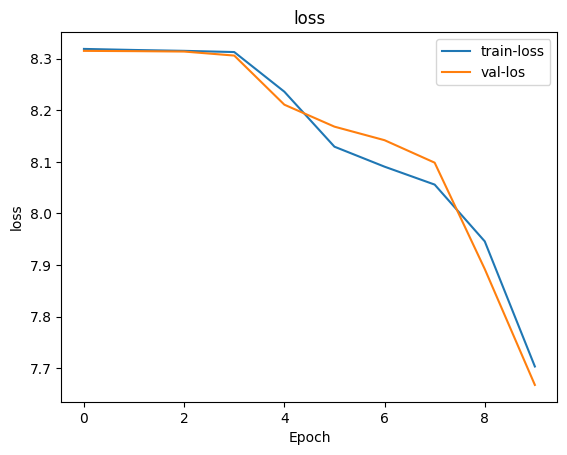

In [11]:
import matplotlib.pyplot as plt

def plot_performance(x, y1, y2, label_1, label_2, label_y):
    plt.plot(x, y1, label = label_1)
    plt.plot(x, y2, label = label_2)
    plt.xlabel('Epoch')
    plt.ylabel(label_y)
    plt.title(label_y)
    plt.legend()
    plt.show()


plot_performance(x=range(epoch),
                 y1=model.history.history['loss'],
                 y2=model.history.history['val_loss'],
                 label_1='train-loss',
                 label_2='val-los',
                 label_y='loss')

#### Looking at the recall of predicting the next song by epoch

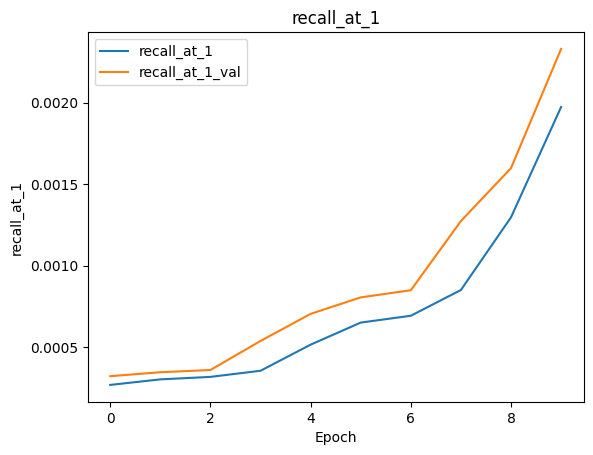

In [12]:
plot_performance(x=range(epoch),
                 y1=model.history.history['recall_at_1'],
                 y2=model.history.history['val_recall_at_1'],
                 label_1='recall_at_1',
                 label_2='recall_at_1_val',
                 label_y='recall_at_1')

#### Save the Query Model

In [13]:
query_tower = model.query_encoder

query_tower.save('query_model/')

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


In [14]:
BUCKET.replace('gs://','')

'spotify-million-playlist-dataset'

In [16]:
from google.cloud import storage
import glob

import glob
import os 
from google.cloud import storage

GCS_CLIENT = storage.Client()
def upload_from_directory(directory_path: str, dest_bucket_name: str, dest_blob_name: str):
    rel_paths = glob.glob(directory_path + '/**', recursive=True)
    bucket = GCS_CLIENT.get_bucket(dest_bucket_name)
    for local_file in rel_paths:
        remote_path = f'{dest_blob_name}/{"/".join(local_file.split(os.sep)[1:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            blob.upload_from_filename(local_file)

dest_blob = 'merlin-processed/query_model_merlin'
upload_from_directory('query_model', BUCKET.replace('gs://',''), dest_blob)

In [15]:
output_workflow_dir

'gs://spotify-million-playlist-dataset/merlin-processed/workflow/'

### Save embeddings to GCS for each song - this will become our Matching Engine index

In [17]:
from merlin.models.utils.dataset import unique_rows_by_features

item_features = (
    unique_rows_by_features(train, Tags.ITEM, Tags.ID)
)

item_features_val = (
    unique_rows_by_features(valid, Tags.ITEM, Tags.ID)
)

In [18]:
item_embs = model.candidate_embeddings(
    item_features, index=item_features.schema['track_uri_can'], batch_size=10000
)

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [19]:
item_embs_val = model.candidate_embeddings(
    item_features_val, index=item_features_val.schema['track_uri_can'], batch_size=10000
)

/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [20]:
# Quick look at the data
item_emb_pd = item_embs_val.compute().to_pandas()
item_emb_pd

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
track_uri_can,,,,,,,,,,,,,,,,,,,,,
0,0.386831,0.000000,0.291807,1.395877,0.969491,0.880086,0.123622,0.068165,0.207112,0.303164,...,0.000000,0.077208,2.800620,0.0,0.000000,2.507491,0.0,0.0,1.193418,0.183100
1,0.217688,0.039090,0.075315,0.000000,0.348324,0.643289,0.197036,0.168014,0.018657,0.510608,...,0.000000,0.398278,0.000000,0.0,0.305815,0.000000,0.0,0.0,0.000000,0.152398
2,0.392541,0.951321,0.000000,0.000000,0.590594,0.164379,0.174118,0.412876,0.000000,0.000000,...,0.209218,0.252147,0.000000,0.0,0.417026,0.000000,0.0,0.0,0.000000,0.167105
3,0.247805,0.299283,0.000000,0.000000,0.405375,0.513006,0.236269,0.237929,0.000000,0.373645,...,0.000000,0.315743,0.000000,0.0,0.298990,0.000000,0.0,0.0,0.000000,0.136691
4,0.132861,0.000000,0.147620,0.263061,0.511410,0.958700,0.126751,0.077214,0.084681,0.498494,...,0.000000,0.286586,0.492636,0.0,0.091007,0.918272,0.0,0.0,0.552747,0.063454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176683,0.000000,0.000000,0.191066,1.263582,0.635999,0.620588,0.164690,0.209504,0.110629,0.132837,...,0.000000,0.030733,2.307123,0.0,0.030140,2.088751,0.0,0.0,1.135281,0.187343
2176796,0.000000,0.000000,0.216706,1.183236,0.312713,0.456104,0.209792,0.280414,0.063878,0.074547,...,0.000000,0.000000,1.780361,0.0,0.178146,1.690233,0.0,0.0,0.798487,0.149461
2176816,0.242435,0.000000,0.387737,1.367530,0.898928,0.841842,0.164866,0.166726,0.124898,0.402353,...,0.000000,0.085471,2.623087,0.0,0.000000,2.259526,0.0,0.0,1.136483,0.218455


In [21]:
%%time
!rm candidate_embeddings.json > /dev/null
!touch candidate_embeddings.json

item_data = pd.read_parquet(os.path.join(BUCKET, "merlin-processed/workflow/2t-spotify-workflow", 'categories/unique.track_uri_can.parquet'))

lookup_dict = dict(item_data['track_uri_can'])

def format_for_matching_engine(data) -> None:
    cols = [str(i) for i in range(layers[-1])] #ensure we are only pulling 0-EMBEDDING_DIM cols
    emb = [data[col] for col in cols]
    formatted_emb = '{"id":"' + str(data['track_uri_can']) + '","embedding":[' + ",".join(str(x) for x in list(emb)) + ']}'
    with open("candidate_embeddings.json", 'a') as f:
        f.write(formatted_emb)
        f.write("\n")
    f.close()

item_emb_pd = item_embs.compute().to_pandas().fillna(1e-10).reset_index() #filling blanks with an epsilon value
item_emb_pd['track_uri_can'] = item_emb_pd['track_uri_can'].apply(lambda l: lookup_dict[l])
_ = item_emb_pd.apply(format_for_matching_engine, axis=1)

item_emb_pd_val = item_embs_val.compute().to_pandas().fillna(1e-10).reset_index() #filling blanks with an epsilon value
item_emb_pd_val['track_uri_can'] = item_emb_pd_val['track_uri_can'].apply(lambda l: lookup_dict[l])
_ = item_emb_pd_val.apply(format_for_matching_engine, axis=1)


rm: cannot remove 'candidate_embeddings.json': No such file or directory
CPU times: user 24min 39s, sys: 33.7 s, total: 25min 12s
Wall time: 25min 33s


In [22]:
!wc -l candidate_embeddings.json

2327831 candidate_embeddings.json


### BE SURE TO RUN `gsutil config` IN TERMINAL TO LOG IN WITH YOUR CREDS

In [ ]:
# !pip install gsutil
import os
candidate_path = os.path.join(BUCKET, 'merlin-processed/embeddings/candidate_embeddings.json')

candidate_path

'gs://spotify-beam-v3/merlin-processed/embeddings/candidate_embeddings.json'

In [ ]:
# !head -2 candidate_embeddings.json

In [ ]:
!mkdir embeddings
!mv candidate_embeddings.json embeddings
dest_blob = 'merlin-processed/embeddings'
upload_from_directory('embeddings', BUCKET.replace('gs://',''), dest_blob)

## All set move to the next notebook - your bucket now should look something like this:

![](img/merlin-bucket.png)